In [156]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pickle
import bz2
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from tools.detector import Detector
from tools.readpandas import Get_Momentum

#from trackml.dataset import load_event, load_dataset
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.models import load_model
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#convert truth direction to local coordinate frame, used to prepare training data
detector = Detector('/Users/pjfox/Dropbox/NN/TrackML/detectors.csv')

def truthmom_to_uvw(a):
    b = detector.GlobalToLocalMom(a[1], a[2], a[3], volid, a[4], a[5])
    norm = np.linalg.norm(b)
    return [b[0], b[1], b[2]]/norm



In [157]:
event = pd.read_pickle("from_squirrel/events10.pkl",compression="bz2")

In [158]:
event.columns

Index(['event_id', 'hit_id', 'particle_id', 'x', 'y', 'z', 'tpx', 'tpy', 'tpz',
       'volume_id', 'layer_id', 'module_id', 'ch0_i', 'ch1_i', 'charge_i',
       'ch0_f', 'ch1_f', 'charge_f', 'nch0', 'nch1'],
      dtype='object')

In [159]:
# select some good hits in a particular volume 
volid=8
goodhits=event.loc[event['particle_id'] != 0]
selectedhits = np.array(goodhits.loc[goodhits['volume_id'] == volid][['hit_id','tpx','tpy','tpz', 'layer_id', 'module_id','ch0_i','ch1_i','charge_i','ch0_f','ch1_f','charge_f', 'nch0', 'nch1']])
print(selectedhits.shape)

(252694, 14)


In [187]:
selectedhits2 = selectedhits#[:5000,]#[:100000,]
directions = np.apply_along_axis(truthmom_to_uvw, 1, selectedhits2)
x = selectedhits2[:,-8:]
y = directions
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.4, random_state=67)

In [188]:
# 2 NN's one uses cosine_proximity one uses mean square error
NNmodel_CP = Sequential()
NNmodel_CP.add(Dense(units=x_train.shape[1], input_dim=x_train.shape[1]))
NNmodel_CP.add(Activation('relu'))
NNmodel_CP.add(Dense(units=x_train.shape[1]))
NNmodel_CP.add(Activation('relu'))
NNmodel_CP.add(Dense(units=int(4 * x_train.shape[1])))
NNmodel_CP.add(Activation('relu'))
NNmodel_CP.add(Dense(units=int(4 * x_train.shape[1])))
NNmodel_CP.add(Activation('relu'))
NNmodel_CP.add(Dense(units=int(2 * x_train.shape[1])))
NNmodel_CP.add(Activation('relu'))
NNmodel_CP.add(Dense(units=y_train.shape[1]))       
NNmodel_CP.compile(optimizer='adam', loss='cosine_proximity', metrics=['accuracy'])

NNmodel_MSE = Sequential()
NNmodel_MSE.add(Dense(units=x_train.shape[1], input_dim=x_train.shape[1]))
NNmodel_MSE.add(Activation('relu'))
NNmodel_MSE.add(Dense(units=x_train.shape[1]))
NNmodel_MSE.add(Activation('relu'))
NNmodel_MSE.add(Dense(units=int(4 * x_train.shape[1])))
NNmodel_MSE.add(Activation('relu'))
NNmodel_MSE.add(Dense(units=int(4 * x_train.shape[1])))
NNmodel_MSE.add(Activation('relu'))
NNmodel_MSE.add(Dense(units=int(2 * x_train.shape[1])))
NNmodel_MSE.add(Activation('relu'))
NNmodel_MSE.add(Dense(units=y_train.shape[1]))       
NNmodel_MSE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [189]:
#train them!
NNmodel_CP_hist=NNmodel_CP.fit(x_train, y_train, epochs=500, batch_size=117, verbose=0, validation_data=[x_test,y_test])
NNmodel_MSE_hist=NNmodel_MSE.fit(x_train, y_train, epochs=500, batch_size=117, verbose=0, validation_data=[x_test,y_test])

In [190]:
#save it/load it
NNmodel_CP.save('Direction_predictor_CP.h5')
NNmodel_MSE.save('Direction_predictor_MSE.h5')
#NNmodel_CP.load_weights('Direction_predictor_CP.h5')
#NNmodel_MSE.load_weights('Direction_predictor_MSE.h5')

In [76]:
NNmodel_MSE.evaluate(x_train, y_train)

30000/30000 [==============================] - 2s 66us/step


[0.18982801161607107, 0.6859666666666666]

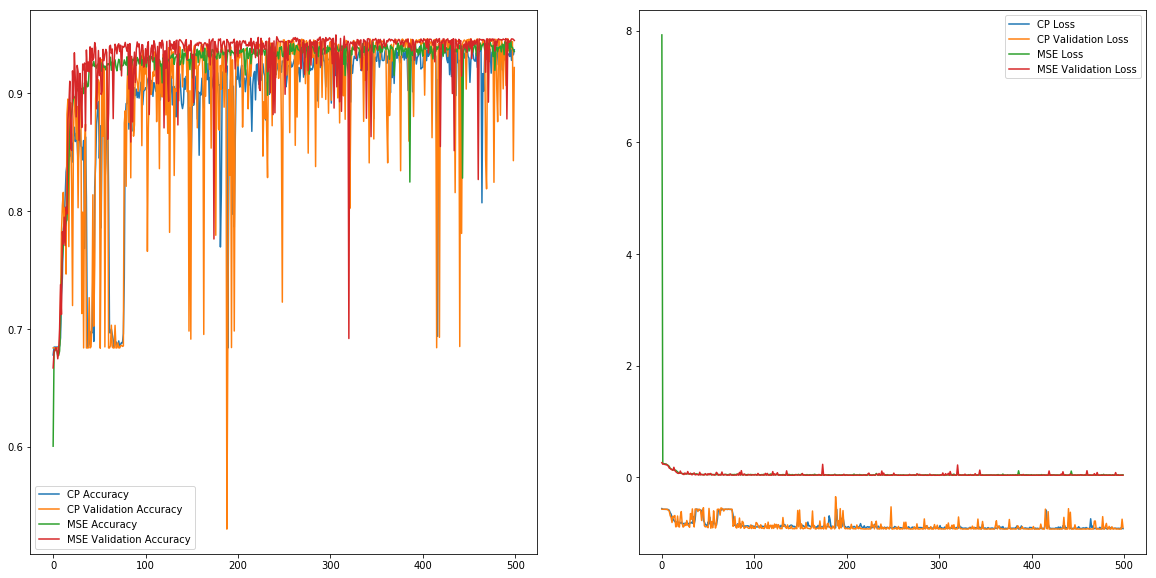

In [191]:
# accuracy etc
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.set_yscale('linear')
ax.set_xscale('linear')
ax.plot(NNmodel_CP_hist.history['acc'], label = 'CP Accuracy')
ax.plot(NNmodel_CP_hist.history['val_acc'], label = 'CP Validation Accuracy')
ax.plot(NNmodel_MSE_hist.history['acc'], label = 'MSE Accuracy')
ax.plot(NNmodel_MSE_hist.history['val_acc'], label = 'MSE Validation Accuracy')
ax.legend()
ax2.set_yscale('linear')
ax2.set_xscale('linear')
ax2.plot(NNmodel_CP_hist.history['loss'], label = 'CP Loss')
ax2.plot(NNmodel_CP_hist.history['val_loss'], label = 'CP Validation Loss')
ax2.plot(NNmodel_MSE_hist.history['loss'], label = 'MSE Loss')
ax2.plot(NNmodel_MSE_hist.history['val_loss'], label = 'MSE Validation Loss')
ax2.legend()

[296 472 0.051220301538705826 300 471 0.002854039892554283 5 2]


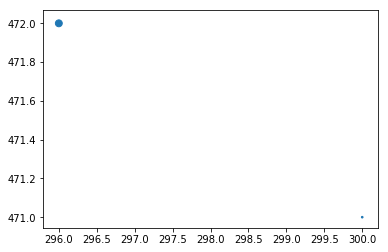

0.35490088071047277


In [144]:
#individual hit, some plots
ii=1
hitwewant = selectedhits[ii]
hitpattern = hitwewant[-8:]
print(hitpattern)
truedirection = truthmom_to_uvw(selectedhits[ii])
predicteddirection = NNmodel.predict(np.reshape(hitpattern,(1,8)),verbose=0)[0]
predicteddirection = predicteddirection/np.linalg.norm(predicteddirection)

xs=np.array([hitpattern[0],hitpattern[3]])
ys=np.array([hitpattern[1],hitpattern[4]])
ss = np.array([50*hitpattern[2]/(hitpattern[2] + hitpattern[5]),50*hitpattern[5]/(hitpattern[2] + hitpattern[5])])
plt.scatter(xs, ys, s=ss)
plt.show()
print(np.sum(truedirection*predicteddirection))

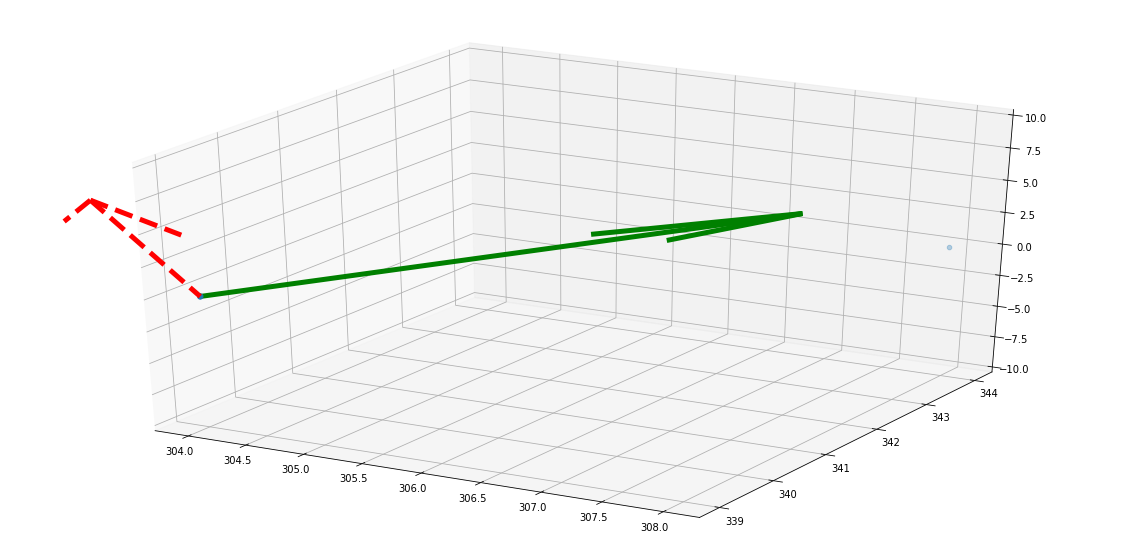

In [115]:
# individual hits, 3D plot
lw=5
jj=1
veclength = np.sqrt((xs.max() - xs.min())**2 + (ys.max() - ys.min())**2)
fig = plt.figure(figsize = (20,10))
ax2 = fig.gca(projection='3d')
ax2.set_zlim([-10,10])
ax2.quiver(xs[jj], ys[jj], 0, truedirection[0], truedirection[1], truedirection[2], length=veclength, normalize=True, color='g',linewidth=lw)
ax2.quiver(xs[jj], ys[jj], 0, predicteddirection[0], predicteddirection[1], predicteddirection[2], length=veclength, normalize=True, color='r',linestyle="--",linewidth=lw)
ax2.scatter(xs, ys, np.zeros(2), s=ss)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arccos


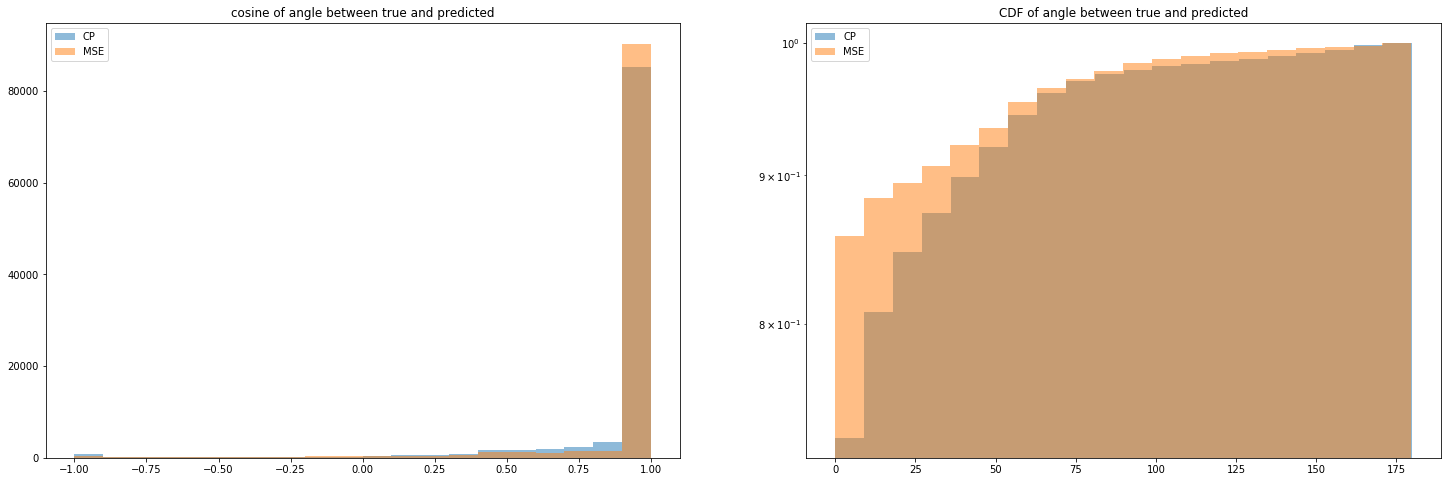

In [197]:
#(cosine of) angle between truth and prediction
def my_norm(x):
    return (x/np.linalg.norm(x))

def predicteddirections(NNmodel, data):
    temp = NNmodel.predict(data)
    temp = np.apply_along_axis(my_norm,1,temp)
    return temp

    
predicteddirection_CP = predicteddirections(NNmodel_CP, x_test)
predicteddirection_MSE = predicteddirections(NNmodel_MSE, x_test)
cosines_CP=np.sum(predicteddirection_CP*y_test,axis=1)
cosines_MSE=np.sum(predicteddirection_MSE*y_test,axis=1)
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(25,8))

ax1.hist(cosines_CP,bins=20,alpha=0.5, label = 'CP')
ax1.hist(cosines_MSE,bins=20,alpha=0.5, label = 'MSE')
ax1.set_title("cosine of angle between true and predicted")
ax1.legend()
ax2.hist(np.arccos(cosines_CP)*180./np.pi,bins=20,alpha=0.5,cumulative=True,density=True, label = 'CP')
ax2.hist(np.arccos(cosines_MSE)*180./np.pi,bins=20,alpha=0.5,cumulative=True,density=True, label = 'MSE')
ax2.set_yscale("log")
ax2.set_title("CDF of angle between true and predicted")
ax2.legend()


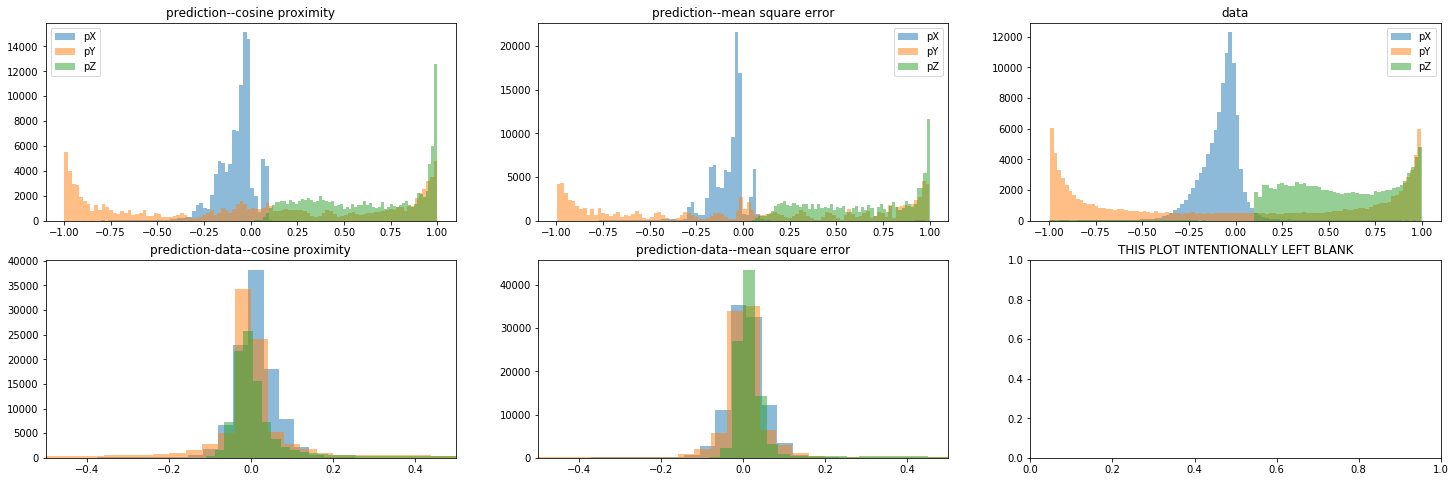

In [202]:
#comparison of data and NN predictions
fig, ax = plt.subplots(2,3,figsize=(25,8))
ax[0,0].hist(predicteddirection_CP[:,0],bins=100,alpha=0.5, label = 'pX')
ax[0,0].hist(predicteddirection_CP[:,1],bins=100,alpha=0.5, label = 'pY')
ax[0,0].hist(predicteddirection_CP[:,2],bins=100,alpha=0.5, label = 'pZ')
ax[0,0].set_title("prediction--cosine proximity")
ax[0,0].legend()
ax[0,1].hist(predicteddirection_MSE[:,0],bins=100,alpha=0.5, label = 'pX')
ax[0,1].hist(predicteddirection_MSE[:,1],bins=100,alpha=0.5, label = 'pY')
ax[0,1].hist(predicteddirection_MSE[:,2],bins=100,alpha=0.5, label = 'pZ')
ax[0,1].set_title("prediction--mean square error")
ax[0,1].legend()
ax[0,2].hist(y_test[:,0],bins=100,alpha=0.5, label = 'pX')
ax[0,2].hist(y_test[:,1],bins=100,alpha=0.5, label = 'pY')
ax[0,2].hist(y_test[:,2],bins=100,alpha=0.5, label = 'pZ')
ax[0,2].set_title("data")
ax[0,2].legend()

ax[1,0].hist(predicteddirection_CP[:,0]-y_test[:,0],bins=100,alpha=0.5)
ax[1,0].hist(predicteddirection_CP[:,1]-y_test[:,1],bins=100,alpha=0.5)
ax[1,0].hist(predicteddirection_CP[:,2]-y_test[:,2],bins=100,alpha=0.5)
ax[1,0].set_xlim(-0.5,0.5)
ax[1,0].set_title("prediction-data--cosine proximity")
ax[1,1].hist(predicteddirection_MSE[:,0]-y_test[:,0],bins=100,alpha=0.5)
ax[1,1].hist(predicteddirection_MSE[:,1]-y_test[:,1],bins=100,alpha=0.5)
ax[1,1].hist(predicteddirection_MSE[:,2]-y_test[:,2],bins=100,alpha=0.5)
ax[1,1].set_xlim(-0.5,0.5)
ax[1,1].set_title("prediction-data--mean square error")

ax[1,2].set_title("THIS PLOT INTENTIONALLY LEFT BLANK")
plt.show()


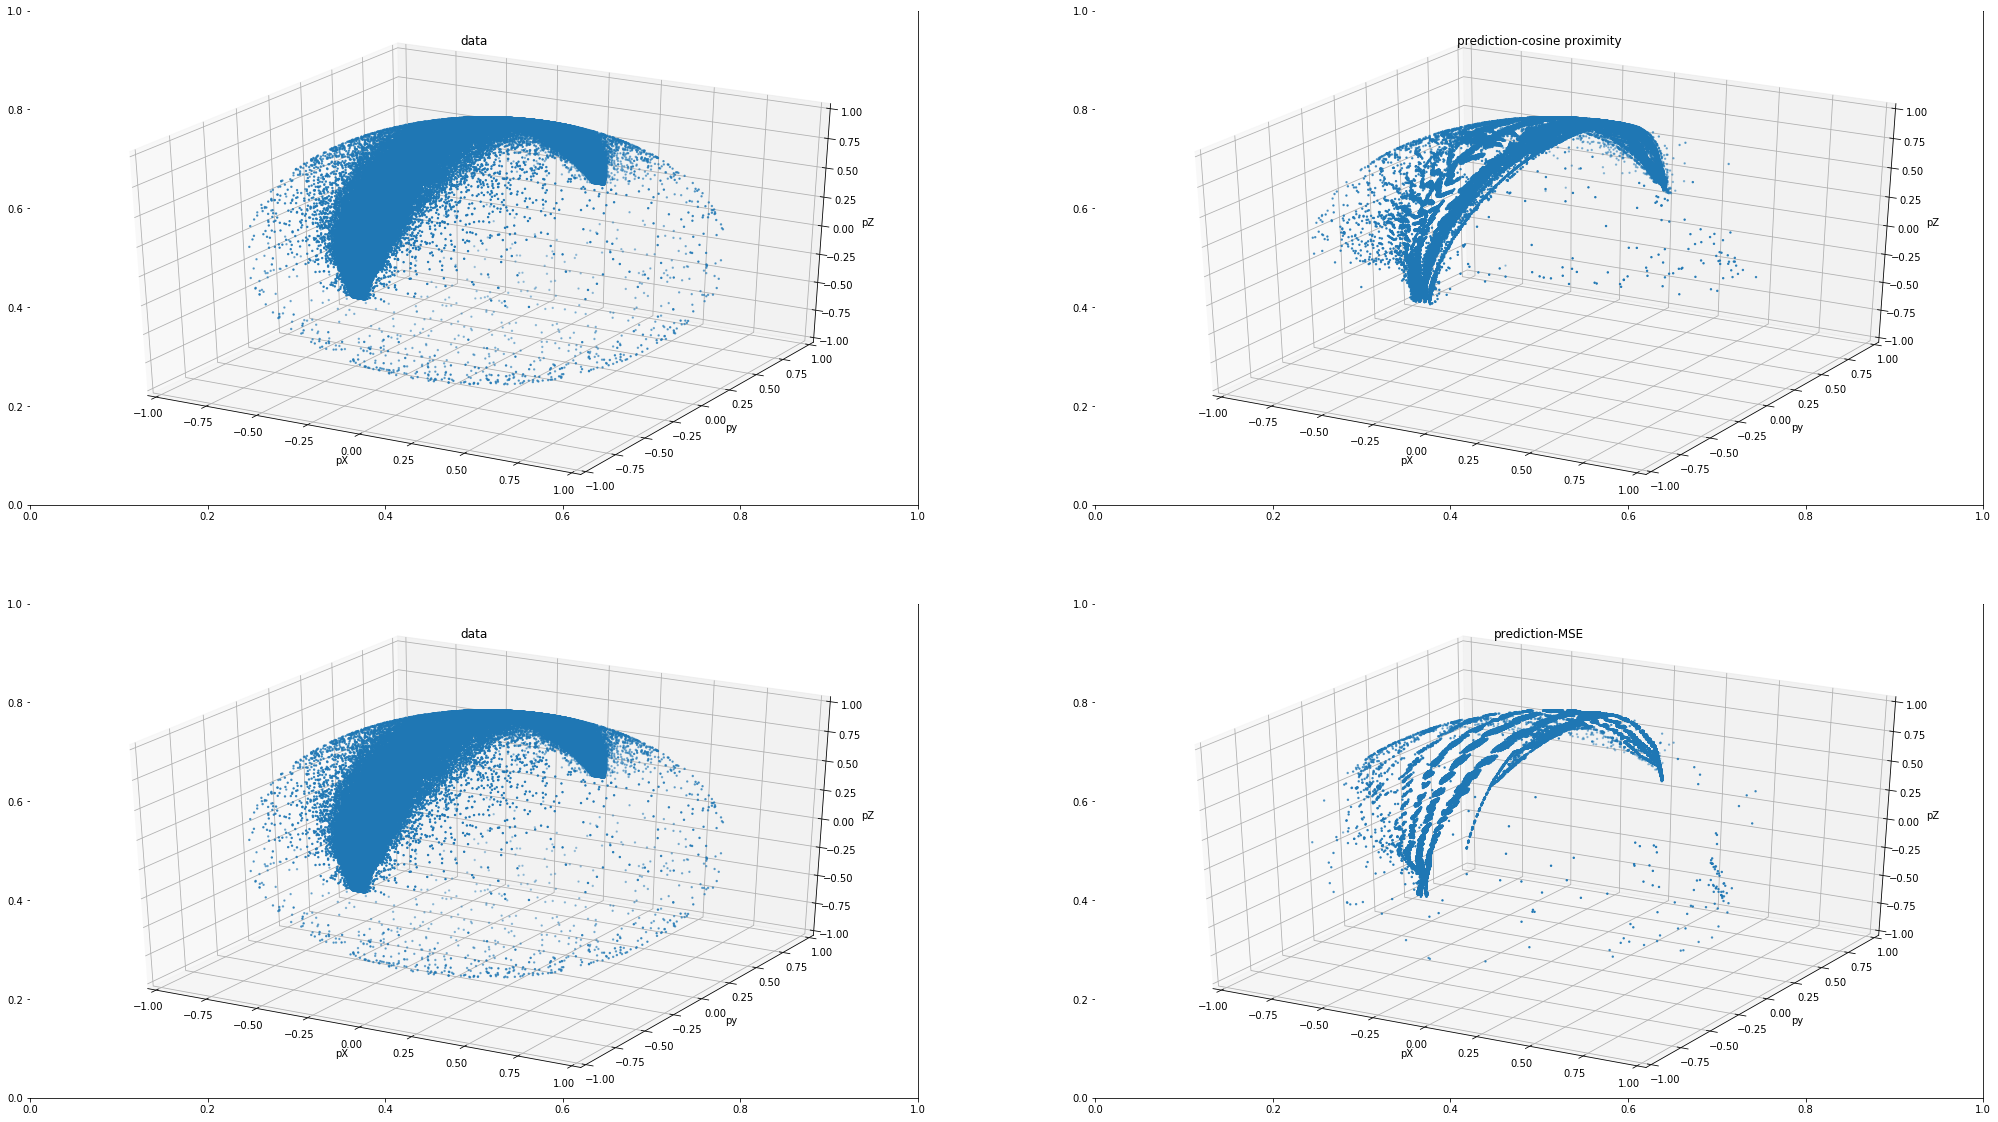

In [194]:
#where the events are located, in local coords
n_num=len(x_test)
names=["data","prediction-cosine proximity","data","prediction-MSE"]
fig, ax = plt.subplots(2,2,figsize=(35,20))
for i,data_list in zip(range(1,5),[y_test,predicteddirection_CP,y_test,predicteddirection_MSE]):
    fig.add_subplot(2,2,i,projection='3d')
    ax = fig.gca(projection='3d')
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)
    ax.set_title(names[i-1])
    ax.set_xlabel("pX")
    ax.set_ylabel("py")
    ax.set_zlabel("pZ")
    ax.scatter(data_list[:n_num,0], data_list[:n_num,1], data_list[:n_num,2],s=2)
   # ax.scatter(data_list[:n_num,0], data_list[:n_num,1], data_list[:n_num,2],s=2)
plt.show()


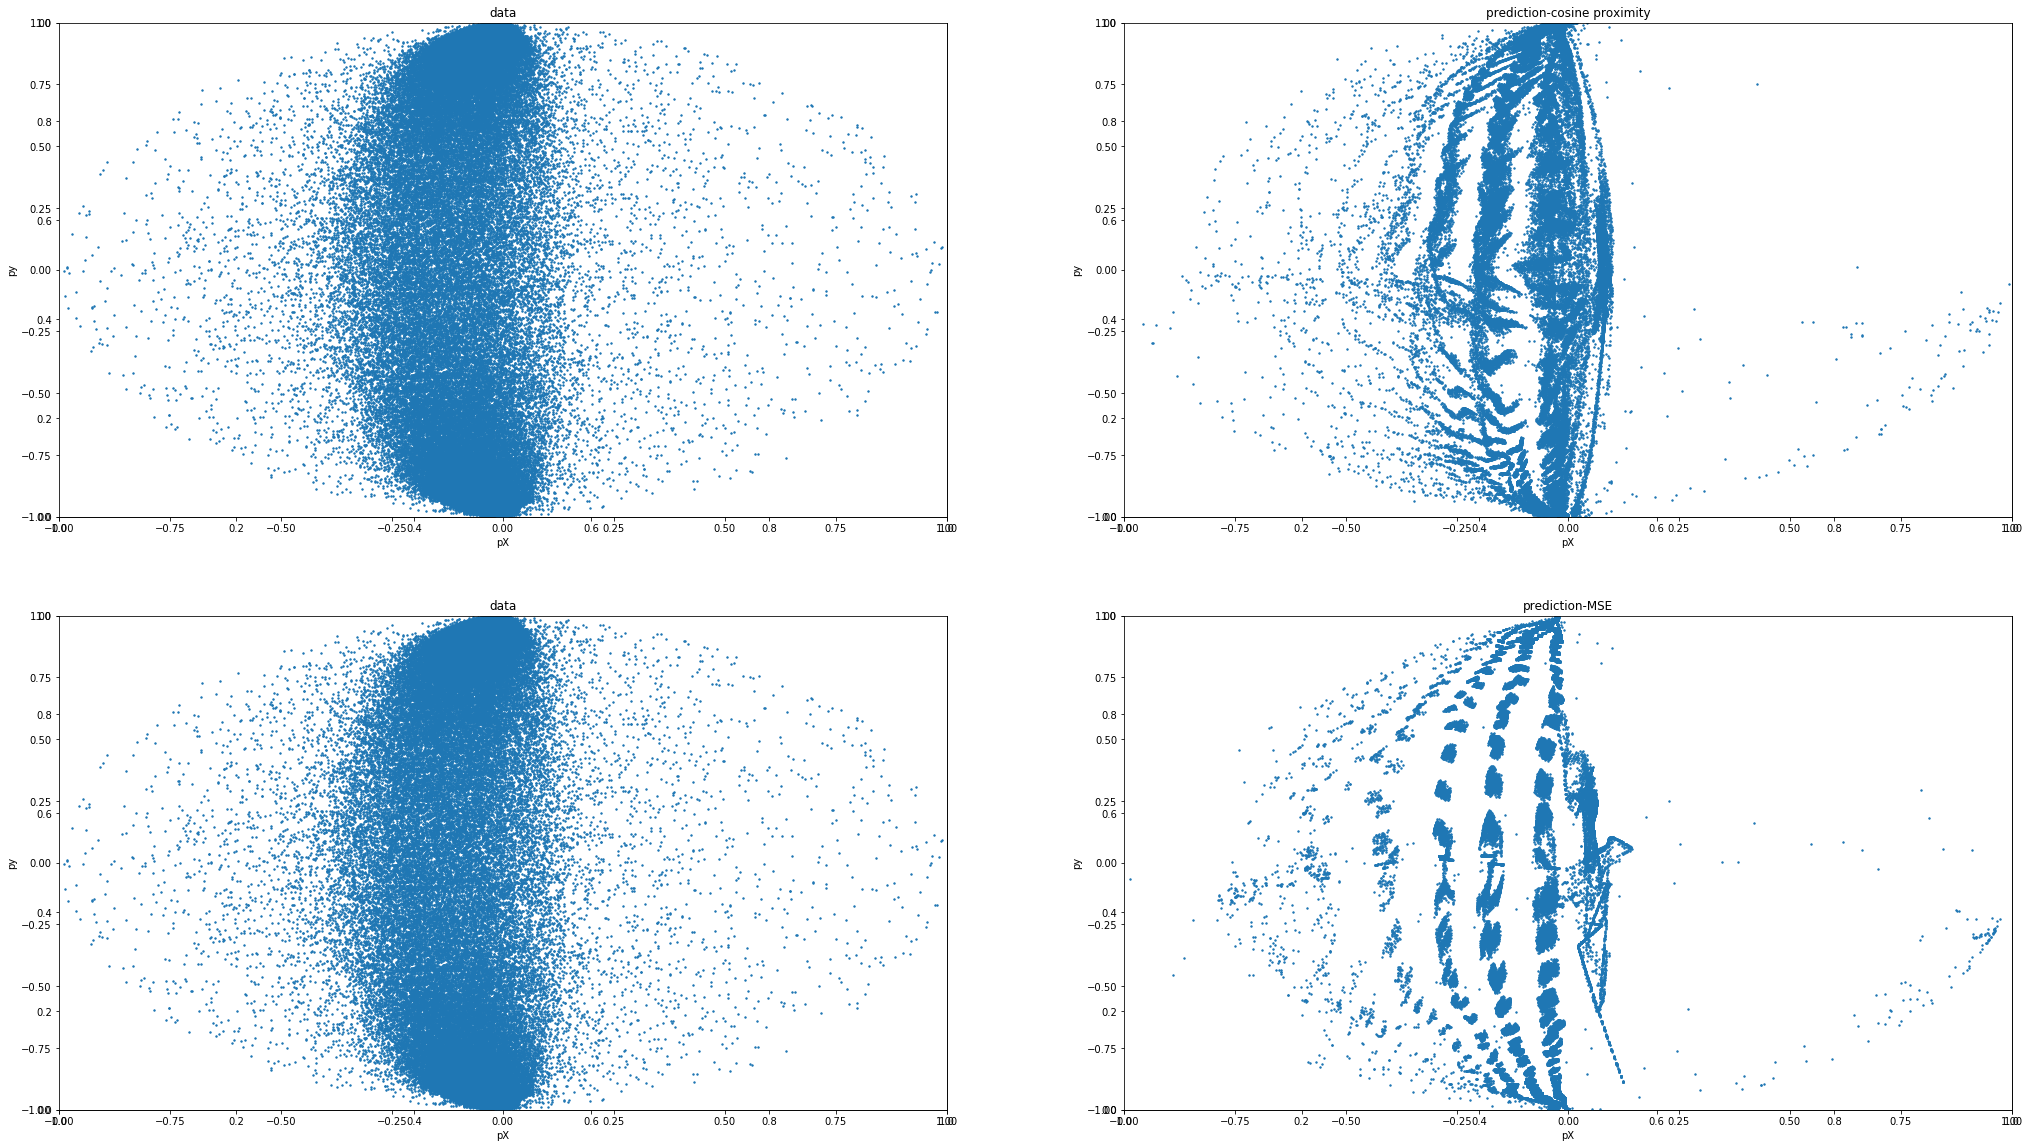

In [200]:
#where the events are located, in local coords
n_num=len(x_test)
names=["data","prediction-cosine proximity","data","prediction-MSE"]
fig, ax = plt.subplots(2,2,figsize=(35,20))
for i,data_list in zip(range(1,5),[y_test,predicteddirection_CP,y_test,predicteddirection_MSE]):
    fig.add_subplot(2,2,i)
    ax = fig.gca()
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(names[i-1])
    ax.set_xlabel("pX")
    ax.set_ylabel("py")
    ax.scatter(data_list[:n_num,0], data_list[:n_num,1],s=2)
   # ax.scatter(data_list[:n_num,0], data_list[:n_num,1], data_list[:n_num,2],s=2)
plt.show()

